In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1697504556601_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1697504556601_0001,pyspark,idle,Link,Link,None,✔


In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
PATH = 's3://yb-p8-data'
PATH_Data = PATH+'/Test1'
PATH_Result = PATH+'/Results'
PATH_PCA = PATH+'/PCA'

print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result+'\nPATH_PCA: '+PATH_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://yb-p8-data
PATH_Data:   s3://yb-p8-data/Test1
PATH_Result: s3://yb-p8-data/Results
PATH_PCA: s3://yb-p8-data/PCA

In [8]:
images_sample = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
images_sample = images_sample.withColumn('label', element_at(split(images_sample['path'], '/'),-2))
print(images_sample.printSchema())
print(images_sample.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------+-----+
|path                                |label|
+------------------------------------+-----+
|s3://yb-p8-data/Test1/287_100.jpg   |Test1|
|s3://yb-p8-data/Test1/r2_217_100.jpg|Test1|
|s3://yb-p8-data/Test1/r_270_100.jpg |Test1|
|s3://yb-p8-data/Test1/302_100.jpg   |Test1|
|s3://yb-p8-data/Test1/95_100.jpg    |Test1|
+------------------------------------+-----+
only showing top 5 rows

None

In [10]:
images_sample.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+-----+
|                path|   modificationTime|length|             content|label|
+--------------------+-------------------+------+--------------------+-----+
|s3://yb-p8-data/T...|2023-10-08 01:16:15|  7227|[FF D8 FF E0 00 1...|Test1|
|s3://yb-p8-data/T...|2023-10-08 01:16:16|  6721|[FF D8 FF E0 00 1...|Test1|
|s3://yb-p8-data/T...|2023-10-08 01:16:16|  6565|[FF D8 FF E0 00 1...|Test1|
|s3://yb-p8-data/T...|2023-10-08 01:16:15|  6514|[FF D8 FF E0 00 1...|Test1|
|s3://yb-p8-data/T...|2023-10-08 01:16:16|  6417|[FF D8 FF E0 00 1...|Test1|
+--------------------+-------------------+------+--------------------+-----+
only showing top 5 rows

In [11]:
lignes = images_sample.count()
colonnes = images_sample.columns
print("Nombre de lignes : ", lignes)
print("Nombre de colonnes : ", len(colonnes))
print("Liste des colonnes : ", colonnes)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Nombre de lignes :  84
Nombre de colonnes :  5
Liste des colonnes :  ['path', 'modificationTime', 'length', 'content', 'label']

In [12]:
model = MobileNetV2(weights='imagenet',include_top=True,input_shape=(224, 224, 3))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [13]:
new_model = Model(inputs=model.input,outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1697504556601_0001/container_1697504556601_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [18]:
features_df = images_sample.repartition(24).select(col("path"), col("label"), featurize_udf("content").alias("features"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
features_df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['path', 'label', 'features']

In [20]:
lignes = features_df.count()
colonnes = features_df.columns
print("Nombre de lignes : ", lignes)
print("Nombre de colonnes : ", len(colonnes))
print("Liste des colonnes : ", colonnes)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Nombre de lignes :  84
Nombre de colonnes :  3
Liste des colonnes :  ['path', 'label', 'features']

# pca

In [21]:
def array_to_vector_udf(arr):
    return Vectors.dense(arr)

array_to_vector_udf = udf(array_to_vector_udf, VectorUDT())

features_df = features_df.withColumn("features", array_to_vector_udf(features_df["features"]))

features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+
|                path|label|            features|
+--------------------+-----+--------------------+
|s3://yb-p8-data/T...|Test1|[0.00816914532333...|
|s3://yb-p8-data/T...|Test1|[0.22056847810745...|
|s3://yb-p8-data/T...|Test1|[0.02453731000423...|
|s3://yb-p8-data/T...|Test1|[9.49188135564327...|
|s3://yb-p8-data/T...|Test1|[0.02011210657656...|
|s3://yb-p8-data/T...|Test1|[0.07047773152589...|
|s3://yb-p8-data/T...|Test1|[0.07834690809249...|
|s3://yb-p8-data/T...|Test1|[1.70806729793548...|
|s3://yb-p8-data/T...|Test1|[0.0,1.3143686056...|
|s3://yb-p8-data/T...|Test1|[1.04676294326782...|
|s3://yb-p8-data/T...|Test1|[5.15967025421559...|
|s3://yb-p8-data/T...|Test1|[0.31317290663719...|
|s3://yb-p8-data/T...|Test1|[0.0,0.3787662386...|
|s3://yb-p8-data/T...|Test1|[0.47895160317420...|
|s3://yb-p8-data/T...|Test1|[0.0,0.3622586429...|
|s3://yb-p8-data/T...|Test1|[0.02039339020848...|
|s3://yb-p8-data/T...|Test1|[0.0,0.0046295342...|


In [23]:
from pyspark.ml.feature import StandardScaler

# Initialisation du StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Calcul des statistiques de standardisation et transformation des données
scaler_model = scaler.fit(features_df)
scaled_features_df = scaler_model.transform(features_df)

# Affichage des données standardisées
scaled_features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+
|                path|label|            features|     scaled_features|
+--------------------+-----+--------------------+--------------------+
|s3://yb-p8-data/T...|Test1|[0.30633217096328...|[-0.2099825306422...|
|s3://yb-p8-data/T...|Test1|[0.11058871448040...|[-0.5376031593024...|
|s3://yb-p8-data/T...|Test1|[0.04312423616647...|[-0.6505201129242...|
|s3://yb-p8-data/T...|Test1|[0.15797266364097...|[-0.4582954803060...|
|s3://yb-p8-data/T...|Test1|[1.61209356784820...|[1.97550237605292...|
|s3://yb-p8-data/T...|Test1|[9.49188135564327...|[-0.7211095262202...|
|s3://yb-p8-data/T...|Test1|[0.51767390966415...|[0.14374532590746...|
|s3://yb-p8-data/T...|Test1|[1.04676294326782...|[1.02929463070182...|
|s3://yb-p8-data/T...|Test1|[0.0,0.3488664329...|[-0.7226982057055...|
|s3://yb-p8-data/T...|Test1|[0.00816914532333...|[-0.7090253066235...|
|s3://yb-p8-data/T...|Test1|[0.00734804105013...|[-0.7103996090039...|
|s3://

In [24]:
def find_optimal_components(df, max_components=20):
    # Créer l'objet PCA et spécifier le nombre de composantes ainsi que les colonnes d'entrée et de sortie
    pca_algo = PCA(k=max_components, inputCol="scaled_features", outputCol="pca_features")
    
    # Appliquer le PCA et obtenir le modèle
    pca_model = pca_algo.fit(df)
    
    # Récupérer les variances expliquées par les composantes
    explained_var = pca_model.explainedVariance
    
    # Créer un graphique pour montrer la variance cumulée expliquée
    plt.figure(figsize=(15, 15))
    plt.plot(np.arange(1, len(explained_var) + 1), np.cumsum(explained_var), marker='s', linestyle='--', color='blue')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained by PCA Components')
    plt.grid(True)
    plt.show()

# Utilisation de la fonction
find_optimal_components(scaled_features_df, max_components=80)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

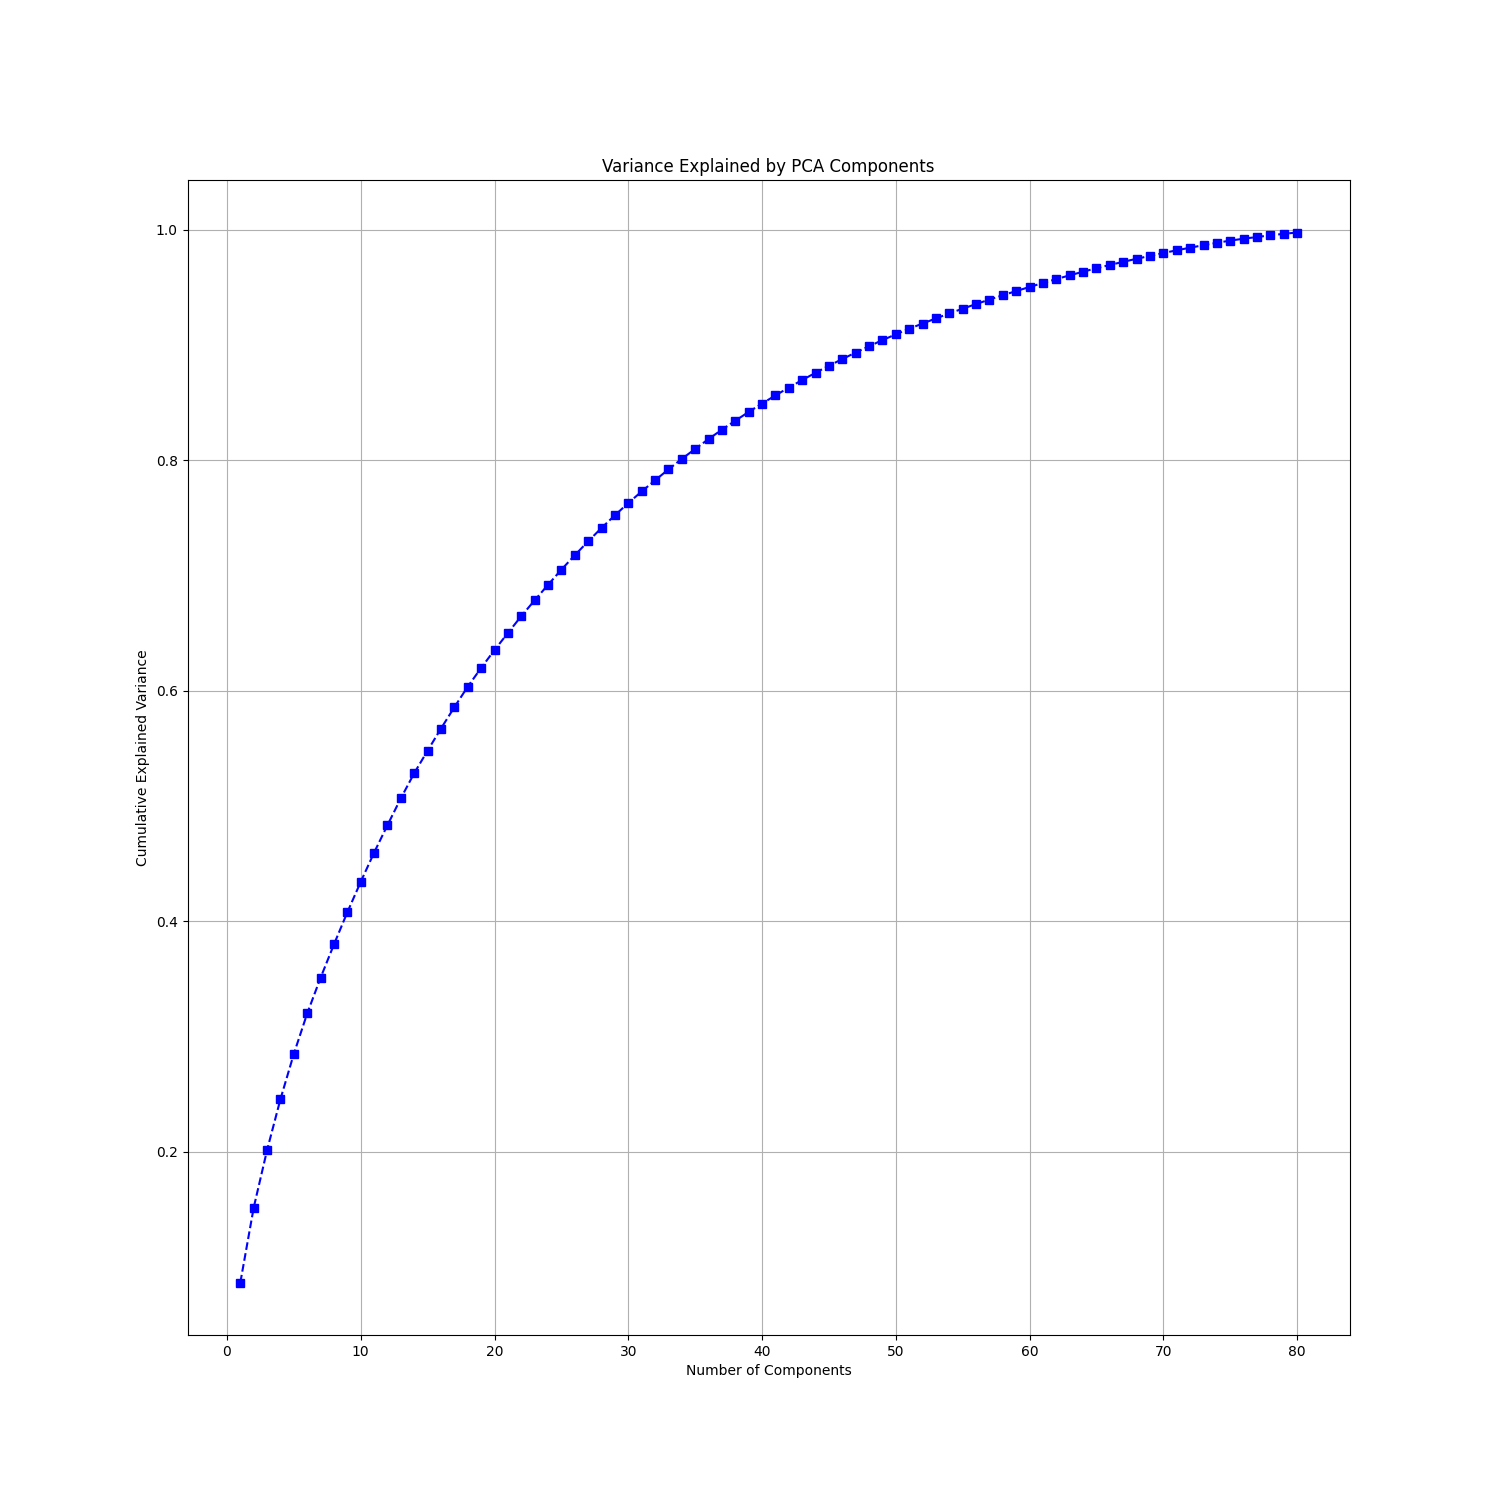

In [25]:
%matplot plt

In [26]:
first_row = features_df.first()
vector = first_row.features
vector_dimension = len(vector)
print(f"La dimension du vecteur de caractéristiques est : {vector_dimension}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

La dimension du vecteur de caract?ristiques est : 1280

In [27]:
from pyspark.ml.feature import PCA
components = 65
pca = PCA(k=components, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(features_df)
pca_result = pca_model.transform(features_df)
pca_result.select("label", "pca_features").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+
|label|        pca_features|
+-----+--------------------+
|Test1|[9.35804603664778...|
|Test1|[1.59249283899508...|
|Test1|[7.58811890139996...|
|Test1|[-2.7100818781887...|
|Test1|[-0.2180708505006...|
|Test1|[-2.9852424954690...|
|Test1|[5.19871339824762...|
|Test1|[1.98897058271275...|
|Test1|[12.9457832019832...|
|Test1|[-1.3187762953499...|
|Test1|[5.16471859822202...|
|Test1|[-4.8361540216391...|
|Test1|[-0.7150806851860...|
|Test1|[7.37981282107568...|
|Test1|[-0.6054464007637...|
|Test1|[8.96813362827972...|
|Test1|[5.74022048486016...|
|Test1|[14.1807168911578...|
|Test1|[-2.2752588631410...|
|Test1|[0.50624010268738...|
+-----+--------------------+
only showing top 20 rows

In [24]:
#pca_model.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
'function' object has no attribute 'mode'
Traceback (most recent call last):
AttributeError: 'function' object has no attribute 'mode'



In [28]:
(pca_result.select("pca_features")).write.mode("overwrite").parquet(PATH_PCA)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
features_df.write.mode("overwrite").parquet(PATH_Result)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# chargement des données enregistrées 

In [30]:
data1 = spark.read.parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
data = data1.select("*").toPandas()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
data.head()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                  path  ...                                           features
0    s3://yb-p8-data/Test1/170_100.jpg  ...  [0.059355542063713074, 0.2432597428560257, 0.0...
1  s3://yb-p8-data/Test1/r_278_100.jpg  ...  [0.020393390208482742, 0.7335812449455261, 0.0...
2   s3://yb-p8-data/Test1/r_90_100.jpg  ...  [0.0, 0.00462953420355916, 0.0, 0.0, 0.0, 0.38...
3     s3://yb-p8-data/Test1/25_100.jpg  ...  [0.5960291624069214, 0.0, 0.09994358569383621,...
4    s3://yb-p8-data/Test1/118_100.jpg  ...  [0.7433980107307434, 0.15267372131347656, 0.0,...

[5 rows x 3 columns]

In [33]:
data.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [34]:
print(data.loc[0,'features'])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.059355542063713074,0.2432597428560257,0.0,0.0,0.2857966125011444,0.1914971023797989,1.0538071393966675,0.0,0.6025503873825073,0.0,0.0,0.0,0.0,0.2911900281906128,0.0,0.40055227279663086,0.0,0.0761578306555748,1.1681829690933228,0.2632983326911926,0.0,0.012814618647098541,0.02027832716703415,0.021099334582686424,0.0,0.0,0.9581245183944702,0.0032239349093288183,0.0,0.16700293123722076,0.0,0.7556307911872864,0.01417289488017559,0.031246604397892952,0.0,0.0,0.4899962246417999,1.1854467391967773,0.008074633777141571,0.3687143921852112,0.3007047772407532,0.0,1.281463384628296,0.404150128364563,0.0,0.0,1.119857907295227,0.0,0.0,0.3839886784553528,0.0,0.2671988606452942,0.0010040925117209554,0.07555367797613144,0.0,1.3577677011489868,0.0,0.0,0.0,0.0,0.0,0.536874532699585,0.011468439362943172,0.06626535207033157,0.8671289682388306,0.0,0.3734789192676544,0.010684577748179436,0.0,1.465081810951233,8.831219020066783e-05,0.6676028370857239,0.17257468402385712,0.00875651091337204,0.032096348702907